# Deux problématiques possibles :
    
> Il arrive qu'au moment des inspections, une situation indépendante de la volonté de l'entreprise puisse impacter négativement les résultats obtenus injustements (comme des ca d'épidémies ou infestations locales). Il serait alors interessant de pouvoir détecter ces évènements, afin de permettre leur analyse et signalement sans pour autant dégrader la réputation d'une entreprise.
    <br>
    
> Dans le cadre de permettre de garantir que les inspections sont le plus fiable possible, nous allons chercher à détecter si certains facteurs, potentiellement discriminants, peuvent biaiser les résultats.

### Problématique 1 : "Clusters épidémiques" 

> Avec en tête que nous chercheons à identifier les sites ayant des reviews négatives ayant potentiellement une cause indépendante de l'entreprise, nous supposons qu'à partir de la date d'insepction et de la localisation des locaux de l'entreprise, il serait possible, grâce à un modèle de clustering type Knn :
<br>
> - d'identifier les inspections ayant eu lieu dans un intervalle de temps et un lieu proches ayant résultés en un état désatisfaisant, ce qui pourrait indiquer une cause commune ponctuelle qui mériterait d'être analysée.
    <br>
> - d'identfier si certains lieux géographiques sont potentiellement plus insalubres et nécessiteraient une intervention ou signalement commun. </p>

### Problématique 2 : "Biais malicieux"

> Avec en tête que nous chercheons à identifier des biais qui pourraient impacter, volontairement ou non, positivement ou négativement, les résultats des inspections, il serait possible, grâce à un modèle de régression :
> - De vérifier si tous les paramètres sont traités équitablements.
> - De voir s'il existe une cause commune à un résultat positif ou négatif d'une inspection, qui ne relève pas des critères évualués.
<br>

> Pour pouvoir étudier cette problématique avec davantage de précision, il faudrait ajouter de la donnée aux rapports. Ces données pourraient venir de sources publiques (API Google Maps, info publiques liées au SIRET...) ou être ajoutées au processus métier (commentaires ou détails de notes d'évaluation...)


In [98]:
# Packages génériques
import sys
import os
import importlib
import numpy as np  # Calcul numérique
import pandas as pd  # Données au format tabulaire, transformation et analyse de données

# Graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl  # pour afficher le numéro de version logicielle
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [64]:
dataset = "export_alimconfiance.csv"

dataset = pd.read_csv(dataset)

dataset.head()

,APP_Libelle_etablissement,SIRET,Adresse_2_UA,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_type_activite
0,SARL AUBERGE DU DOUBLE SIX,30121048000010,24 PL GENERAL LECLERC,80220,GAMACHES,16793484,2023-04-25T02:00:00+02:00,Restaurant,Satisfaisant,NaN,"49.985274, 1.561386",Restaurant,Autres
1,MONSIEUR PHILIPPE MARIOTTE,31084873400029,286 RUE DU CENTRE,74260,LES GETS,16740394,2023-02-23T01:00:00+01:00,Restaurant,Satisfaisant,NaN,"46.15861, 6.677963",Restaurant,Autres
2,NATURALIA (NATURALIA FRANCE),30247464801894,36 RUE EUGENE EICHENBERGER,92800,PUTEAUX,16611978,2022-10-04T02:00:00+02:00,Alimentation générale,Satisfaisant,NaN,"48.881317, 2.23746",Alimentation générale,Autres
3,SUPER-U (COLOMBELLES DISTRIBUTION),30122377200031,RD 403,14460,COLOMBELLES,16787460,2023-04-20T02:00:00+02:00,Rayon boucherie-charcuterie,Très satisfaisant,NaN,NaN,Rayon boucherie-charcuterie,Autres
4,FRANPRIX (SOC DISTRIBUTION SODISCO SARL),33427109500013,"4, PLACE DU MOUSTIER",92210,SAINT CLOUD,16748988,2023-03-08T01:00:00+01:00,Alimentation générale,A améliorer,NaN,"48.844091, 2.219818",Alimentation générale,Autres


In [65]:
# Remove useless columns
COLUMNS_NON_HIERAR = ["APP_Libelle_etablissement", "Adresse_2_UA", "Code_postal", "Libelle_commune", "APP_Libelle_activite_etablissement", "geores", "filtre", "ods_type_activite"] 
COLUMNS_HIERRAR = ["Synthese_eval_sanit", "Date_inspection"]
dataset = dataset[COLUMNS_NON_HIERAR + COLUMNS_HIERRAR]

dataset.describe()

,APP_Libelle_etablissement,Adresse_2_UA,Code_postal,Libelle_commune,APP_Libelle_activite_etablissement,geores,filtre,ods_type_activite,Synthese_eval_sanit,Date_inspection
count,32719,32292,32720,32720,32720,31961,24086,32720,32720,32720
unique,25744,27101,4989,8460,149,26914,94,7,4,299
top,ECOLE PRIMAIRE PUBLIQUE,LE BOURG,75015,Paris 15e Arrondissement,Restaurant,"48.859, 2.347",Restaurant,Autres,Satisfaisant,2023-04-04T02:00:00+02:00
freq,162,91,557,536,11653,50,11653,24737,17976,251


### PB 1 Hypothèse 2

#### Analyse et restriction des données

> Puisque nous cherchons à identifier les clusters insalubres, nous allons resteindre notre sélection de données aux évalutions insatisfaisantes.

In [72]:
COLUMNS_OF_INTEREST = ["Synthese_eval_sanit", "geores"]


data = dataset.copy() # MAKE A CLEAN SLATE COPY FOR THIS SEGMENT


# SEARCH DATA KEYS TO KEEP
for name, group_data in data.groupby("Synthese_eval_sanit"):
    print(name)

A améliorer
A corriger de manière urgente
Satisfaisant
Très satisfaisant


> - Data conservée : "A améliorer" + "A corriger de manière urgente". Nous n'avons pas besoin de distinguer l'un de l'autre, alors nous ne nourrirrons pas cette information au modèle.
<br>

> Egalement Afin de simplifier la visualisation des résultats, nous allons chercher a cantonner nos résultats à la France métropolitaine. Pour cela, nous n'allons conservé que la donnée d'une latitude supérieure à 30.

In [75]:
# DROP USELESS COLUMNS, RESTRICT DATA

df = data[COLUMNS_OF_INTEREST].dropna()

# TRANSFORM "geores" BY SPLITTING IT IN "longitude", "latitude"
df[['lat', 'lng']] = df['geores'].str.split(', ', expand=True).astype(float)
df = df.drop('geores', axis=1)

# REMOVE USELESS ROWS
df = df[(df['Synthese_eval_sanit'] == 'A améliorer') | (df['Synthese_eval_sanit'] == 'A corriger de manière urgente')]
df = df[df['lat'] > 30]

df.describe()

,lat,lng
count,1940.000000,1940.000000
mean,47.293139,2.527574
std,2.193290,2.272321
min,41.938073,-4.759437
25%,45.450000,1.615195
50%,48.334387,2.351357
75%,48.885000,3.583333
max,50.961239,9.465493


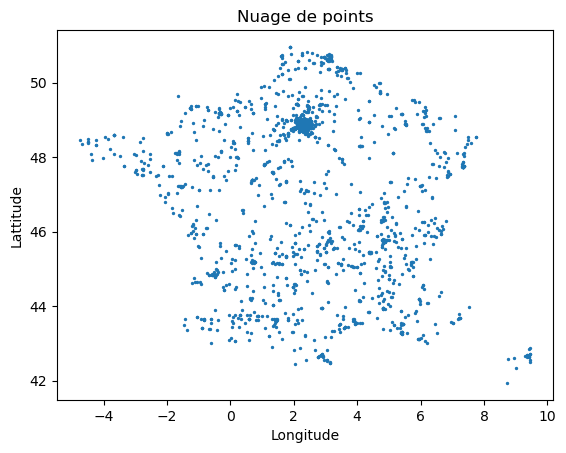

In [76]:
# Visualise and analyse data

plt.scatter(df['lng'], df['lat'], s=2)

plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.title('Nuage de points')

plt.show()

> Nous remarquons un gros problème immédiatement : il y a une grande concentration de données en région parisienne par rapport au reste de la France. Nous allons, dans un premier temps, chercher à l'ignorer, et si cela prouve être un trop gros problème, chercherons un traitement approprié.

### Première version : Modèle avec 800 clusters, 10 inspections insatisfaisantes pour qu'un cluster soit considéré comme "insalubre"

In [77]:
# CREATE INITIAL MODEL AND EVALUATE

df_cluster = df.copy()

# COUNT OF CLUSTER WANTED
k = 800

# CREATE KMEANS MODEL
kmeans = KMeans(n_clusters=k, n_init="auto")

# FIT UNSUPERVISED MODEL
kmeans.fit(df_cluster[['lat', 'lng']])

# SAVE LABELS GENERATED BY MODEL
labels = kmeans.labels_

# ADD LABELS TO THE DATAFRAME
df_cluster['Cluster'] = labels

df_cluster.head()

,Synthese_eval_sanit,lat,lng,Cluster
4,A améliorer,48.844091,2.219818,674
6,A améliorer,48.448928,-4.249809,271
19,A améliorer,47.807466,1.078596,509
20,A améliorer,45.057360,5.770684,771
21,A améliorer,48.794437,2.155045,333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


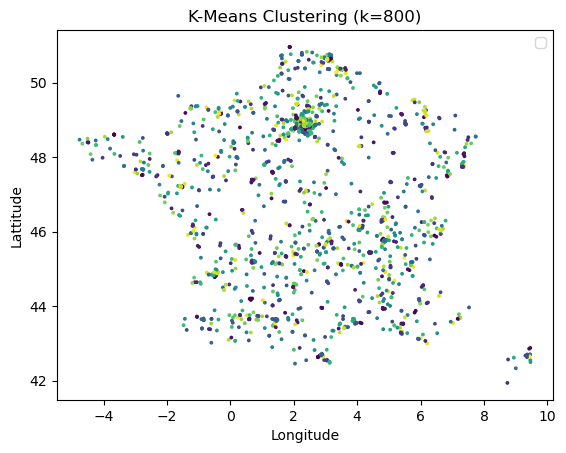

In [78]:
plt.scatter(df_cluster['lng'], df_cluster['lat'], c=labels, cmap='viridis', s=3)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=2, label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.title(f'K-Means Clustering (k={k})')
plt.legend()
plt.show()

> Une fois les clusters identifiés par le modèle, nous n'allons conserver que les clusters qui présentent une concentration anormale de lieu insatisfaisants.

In [79]:
# ONLY KEEP CLUSTERS WITH A SIZE BIGGER THAN THE VARIABLE DEFINED

max_size = 10

clusters = df_cluster.groupby('Cluster').count()[df_cluster.groupby('Cluster').count()['lat'] > max_size].index.tolist()
len(clusters)

24

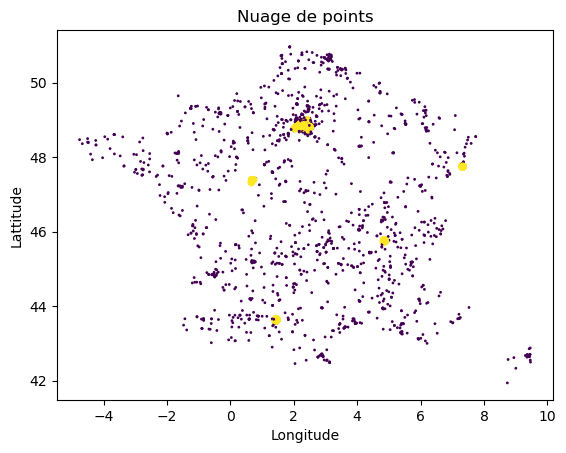

In [80]:
# COLOR CODING FOR VISUALISATION
def set_cluster(row):
    if row['Cluster'] in clusters:
        return 20
    else:
        return 1

df_cluster['Color'] = df_cluster.apply(set_cluster, axis=1)

plt.scatter(df_cluster['lng'], df_cluster['lat'], s=df_cluster['Color'], c=df_cluster['Color'])

# ADD LABELS AND A TITLE
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.title('Nuage de points')

# DISPLAY GRAPH
plt.show()

> Le dataset comprends une grande concentration d'inspection en région parisienne, d'où la présence d'un grand nombre de clusters sur ce lieu.
<br> Nous allons donc essayer d'améliorer le modèle afin d'obtenir moins de clusters en région parisienne et protentiellement davantage de clusters en dehors de celle ci. Pour cela, nous allons réduire le nombre le cluster, ce qui aura pour effet d'augmenter leur taille.    



### Deuxieme version : 200 Clusters

In [81]:
# CREATE INITIAL MODEL AND EVALUATE

df_cluster = df.copy()

# COUNT OF CLUSTER WANTED
k = 200

# CREATE KMEANS MODEL
kmeans = KMeans(n_clusters=k, n_init="auto")

# FIT UNSUPERVISED MODEL
kmeans.fit(df_cluster[['lat', 'lng']])

# SAVE LABELS GENERATED BY MODEL
labels = kmeans.labels_

# ADD LABELS TO THE DATAFRAME
df_cluster['Cluster'] = labels

df_cluster.head()

,Synthese_eval_sanit,lat,lng,Cluster
4,A améliorer,48.844091,2.219818,162
6,A améliorer,48.448928,-4.249809,192
19,A améliorer,47.807466,1.078596,97
20,A améliorer,45.057360,5.770684,47
21,A améliorer,48.794437,2.155045,64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


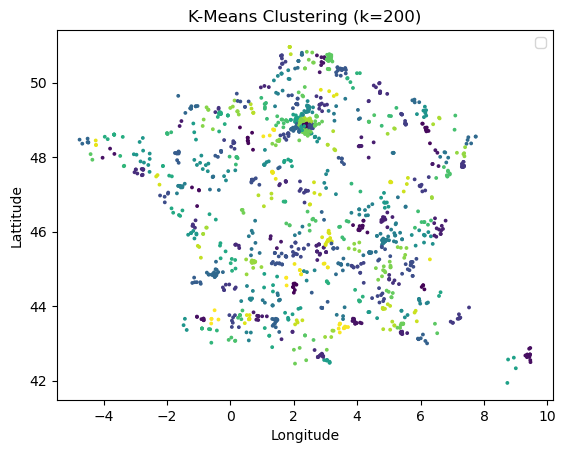

In [83]:
# VISUALIZE RESULTS
plt.scatter(df_cluster['lng'], df_cluster['lat'], c=labels, cmap='viridis', s=3)
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.title(f'K-Means Clustering (k={k})')
plt.legend()
plt.show()

> Comme le nombre de cluster a été réduit, nous allons augmenter la densité minimale pour qu'un cluster soit conservé

In [84]:
max_size = 15

clusters = df_cluster.groupby('Cluster').count()[df_cluster.groupby('Cluster').count()['lat'] > 15].index.tolist()
len(clusters)

18

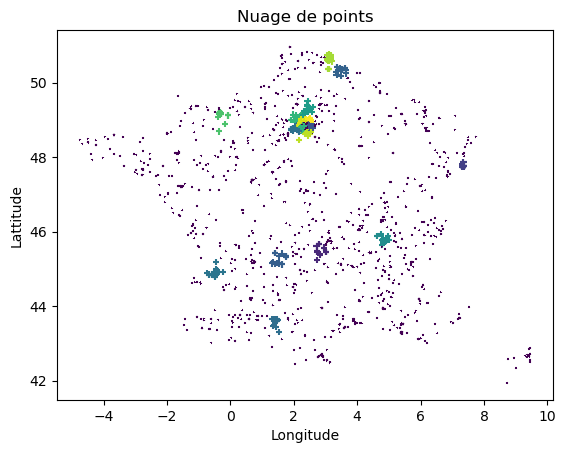

In [86]:
# COLOR AND SIZE CODING FOR VISUALISATION
def set_size(row):
    if row['Cluster'] in clusters:
        return 20
    else:
        return 1
    
def set_color(row):
    if row['Cluster'] in clusters:
        return row['Cluster']
    else:
        return 0


df_cluster['Size'] = df_cluster.apply(set_size, axis=1)
df_cluster['Color'] = df_cluster.apply(set_color, axis=1)

plt.scatter(df_cluster['lng'], df_cluster['lat'], s=df_cluster['Size'], c=df_cluster['Color'], marker="+")

plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.title('Nuage de points')

plt.show()

> Malgré une amélioration du nombre de clusters hors de Paris, il y a toujours un grand nombre de ceux ci dans le bassin de la capitale. Nous allons donc chercher à ajouter la région au modèle, afin qu'il puisse grouper un plus grand nombre de points de Paris dans un seul cluster.

### Version 3 : Ajout du libellé de région

In [90]:
# Clean data is needed
COLUMNS_OF_INTEREST = ["Synthese_eval_sanit", "geores", "Libelle_commune"]

# Repeat data selection of Version 1 and 2
df = dataset[COLUMNS_OF_INTEREST].dropna()
df[['lat', 'lng']] = df['geores'].str.split(', ', expand=True).astype(float)
df = df.drop('geores', axis=1)
df = df[(df['Synthese_eval_sanit'] == 'A améliorer') | (df['Synthese_eval_sanit'] == 'A corriger de manière urgente')]
df = df[df['lat'] > 30]

# Add Region to the final dataframe
label_encoder = LabelEncoder()
df['Libelle_commune'] = label_encoder.fit_transform(df['Libelle_commune'])

df.describe()

,Libelle_commune,lat,lng
count,1940.000000,1940.000000,1940.000000
mean,597.109278,47.293139,2.527574
std,327.342837,2.193290,2.272321
min,0.000000,41.938073,-4.759437
25%,311.750000,45.450000,1.615195
50%,655.000000,48.334387,2.351357
75%,844.250000,48.885000,3.583333
max,1156.000000,50.961239,9.465493


In [92]:
# CREATE INITIAL MODEL AND EVALUATE

df_cluster = df.copy()

# COUNT OF CLUSTER WANTED
k = 200

# CREATE KMEANS MODEL
kmeans = KMeans(n_clusters=k, n_init="auto")

# FIT UNSUPERVISED MODEL
kmeans.fit(df_cluster[['lat', 'lng', 'Libelle_commune']])

# SAVE LABELS GENERATED BY MODEL
labels = kmeans.labels_

# ADD LABELS TO THE DATAFRAME
df_cluster['Cluster'] = labels

df_cluster.head()

,Synthese_eval_sanit,Libelle_commune,lat,lng,Cluster
4,A améliorer,878,48.844091,2.219818,0
6,A améliorer,451,48.448928,-4.249809,89
19,A améliorer,881,47.807466,1.078596,188
20,A améliorer,1066,45.057360,5.770684,4
21,A améliorer,1061,48.794437,2.155045,76


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


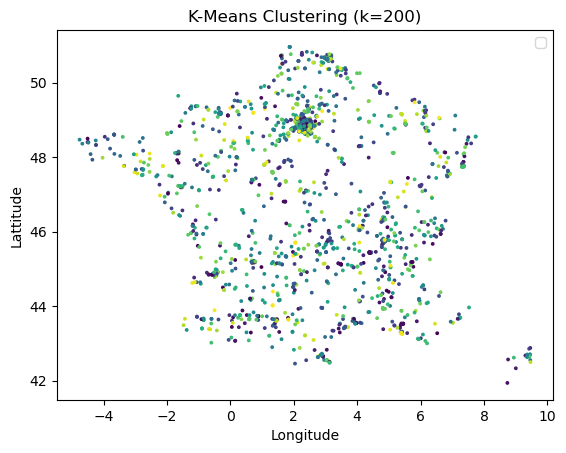

In [93]:
# VISUALIZE RESULTS
plt.scatter(df_cluster['lng'], df_cluster['lat'], c=labels, cmap='viridis', s=3)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=2, label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.title(f'K-Means Clustering (k={k})')
plt.legend()
plt.show()

In [94]:
max_size = 15

clusters = df_cluster.groupby('Cluster').count()[df_cluster.groupby('Cluster').count()['lat'] > 15].index.tolist()
len(clusters)

15

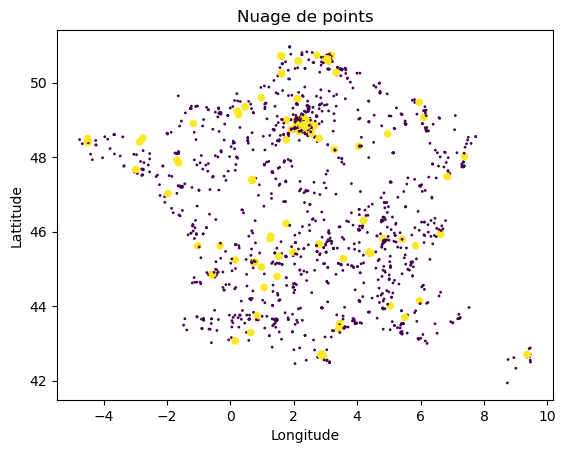

In [95]:
# COLOR AND SIZE CODING FOR VISUALISATION
def set_size(row):
    if row['Cluster'] in clusters:
        return 20
    else:
        return 1
    
def set_color(row):
    if row['Cluster'] in clusters:
        return row['Cluster']
    else:
        return 0

df_cluster['Size'] = df_cluster.apply(set_size, axis=1)
df_cluster['Color'] = df_cluster.apply(set_color, axis=1)

plt.scatter(df_cluster['lng'], df_cluster['lat'], s=df_cluster['Size'], c=df_cluster['Size'])

plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.title('Nuage de points')

plt.show()

> Encore une plutot nette amélioration du nomnbre de clusters et de leur répartition, on note qu'il y a toujours un nombre important de clusters sur Paris.
> Il serait peut être possible d'isoler le bassin parisien et le traiter à part, cependant, nous craignons que le même schéma se répète ensuite sur Lyon, puis Lille, puis Marseille, etc etc.

> Nous choississons donc de nous arrêter la pour cette hypothèse, qui serait difficile à confirmer à 100% sans une donnée mieux répartie.

### PB 1 Hypothèse 1

> A peu près la même chose que l'hypothèse 2, mais cette fois ci avec l'ajout d'une dimension temporelle (pour identifier un problème ponctuelle).

> La donnée sera donc visualisée à l'aide d'un graph en 3 dimensions.

In [101]:
COLUMNS_OF_INTEREST = ["Synthese_eval_sanit", "geores", "Libelle_commune", "Date_inspection"]

df = data[COLUMNS_OF_INTEREST].dropna()
df[['lat', 'lng']] = df['geores'].str.split(', ', expand=True).astype(float)
df = df.drop('geores', axis=1)
df = df[(df['Synthese_eval_sanit'] == 'A améliorer') | (df['Synthese_eval_sanit'] == 'A corriger de manière urgente')]
df = df[df['lat'] > 30]
label_encoder = LabelEncoder()
df['Libelle_commune'] = label_encoder.fit_transform(df['Libelle_commune'])
df['Date_inspection'] = df['Date_inspection'].apply(lambda x: datetime.fromisoformat(x).timestamp())
df.describe()

,Libelle_commune,Date_inspection,lat,lng
count,1940.000000,1.940000e+03,1940.000000,1940.000000
mean,597.109278,1.681647e+09,47.293139,2.527574
std,327.342837,7.901530e+06,2.193290,2.272321
min,0.000000,1.662941e+09,41.938073,-4.759437
25%,311.750000,1.676333e+09,45.450000,1.615195
50%,655.000000,1.684109e+09,48.334387,2.351357
75%,844.250000,1.687997e+09,48.885000,3.583333
max,1156.000000,1.692230e+09,50.961239,9.465493


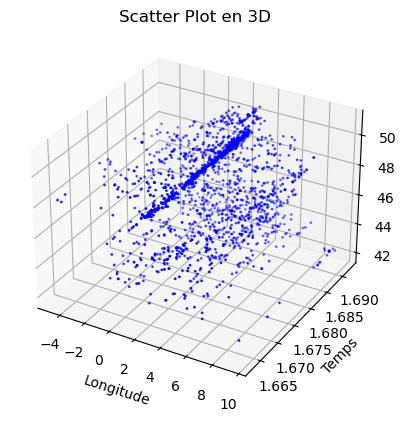

In [102]:
# CREATE 3D GRAPH
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['lng'], df['Date_inspection'], df['lat'], c='b', marker='o', s=1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Temps')
ax.set_zlabel('Lattitude')

plt.title('Scatter Plot en 3D')

plt.show()

#### Définition du modèle : 400 clusters, 8 entrées insatisfaisantes pour être considéré comme anormal

In [103]:
k = 400

kmeans = KMeans(n_clusters=k)

kmeans.fit(df[['lat', 'lng', 'Date_inspection']])

labels = kmeans.labels_

df['Cluster'] = labels

df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Synthese_eval_sanit,Libelle_commune,Date_inspection,lat,lng,Cluster
4,A améliorer,878,1.678234e+09,48.844091,2.219818,382
6,A améliorer,451,1.675728e+09,48.448928,-4.249809,359
19,A améliorer,881,1.664150e+09,47.807466,1.078596,233
20,A améliorer,1066,1.685491e+09,45.057360,5.770684,26
21,A améliorer,1061,1.674518e+09,48.794437,2.155045,251


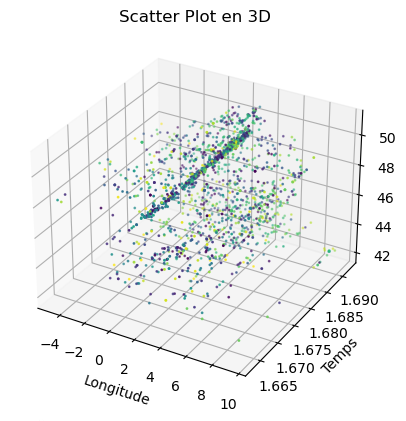

In [104]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['lng'], df['Date_inspection'], df['lat'], c=labels, cmap='viridis', marker='o', s=1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Temps')
ax.set_zlabel('Lattitude')

plt.title('Scatter Plot en 3D')

plt.show()

In [105]:
clusters = df.groupby('Cluster').count()[df.groupby('Cluster').count()['lat'] > 8].index.tolist()
len(clusters)

49

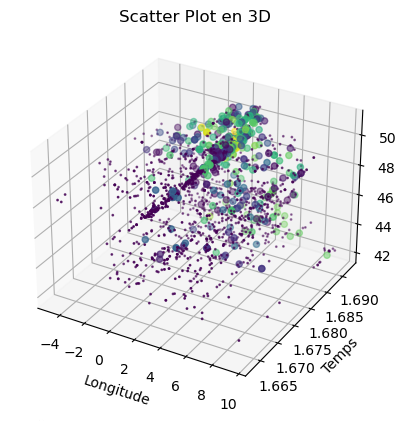

In [107]:
def set_size(row):
    if row['Cluster'] in clusters:
        return 20
    else:
        return 1
    
def set_color(row):
    if row['Cluster'] in clusters:
        return row['Cluster']
    else:
        return 0

df['Size'] = df.apply(set_size, axis=1)
df['Color'] = df.apply(set_color, axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['lng'], df['Date_inspection'], df['lat'], c=df['Color'], marker='o', s=df['Size'])

ax.set_xlabel('Longitude')
ax.set_ylabel('Temps')
ax.set_zlabel('Lattitude')

plt.title('Scatter Plot en 3D')

plt.show()

> On remarque alors qu'un grand nombre de clusters semblent apparaitre vers les entrées les plus récentes. Deux conclusions possibles :
> - La situation sanitaire s'est lourdement dégradée ces derniers temps
> - Le nombres d'inspections sanitaires à augmentée récemment.

> Puisque nos donneés ne couvrent qu'une période de deux ans, nous penchons vers la seconde conclusion. Cependant, avec plus de données, il est fort probable que nous puissons valider la premiere conclusion également, et donc notre modèle.